In [1]:
import warnings
warnings.filterwarnings('ignore')

from typing import List
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import keras
import random
from joblib import load
from pandas.tseries.offsets import BDay
from pypfopt import expected_returns
from sklearn.preprocessing import MinMaxScaler

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [10, 5]
plt.rc('figure', autolayout=True)

In [2]:
from src.variables import tickers, period, observation_window, seed

ticker = tickers[0]
graphics: bool = True

In [3]:
random.seed(seed)
np.random.seed(seed)

In [4]:
data: pd.DataFrame = pd.read_csv(f'./results/data/{ticker}.csv', index_col='Date', parse_dates=True)
train_label: str = f"{ticker} period {data.index.min().strftime('%Y-%m-%d')} - {data.index.max().strftime('%Y-%m-%d')}"

In [5]:
df_test: pd.DataFrame = data[data.index >= pd.Timestamp(period['boundary'])][['Adj Close']]

In [6]:
scaler: MinMaxScaler = load(f'./results/serialized objects/{train_label}/scaler.joblib')
model: keras.models.Model = keras.models.load_model(f'./results/trained models/{train_label}/model.h5')

In [7]:
X_test: pd.DataFrame = data[['Adj Close']].iloc[-observation_window['stepsBack'] - observation_window['stepsFoward'] : - observation_window['stepsFoward']]
scaler_X_test: np.ndarray = scaler.transform(X_test)
scaled_adj_close_test: np.ndarray = model.predict(scaler_X_test.reshape(1, -1, 1))
np_adj_close_test: np.ndarray = scaler.inverse_transform(scaled_adj_close_test)

adj_close_test: pd.DataFrame = pd.DataFrame(
    np_adj_close_test.reshape(-1, 1),
    index=data[-observation_window['stepsFoward']:].index,
    columns=['Adj Close Test']
)

1/1 [==============================] - 2s 2s/step


In [8]:
X_temp: pd.DataFrame = data[['Adj Close']].iloc[-observation_window['stepsBack']:]
scaler_X_temp: np.ndarray = scaler.transform(X_temp)
scaled_adj_close_forecast: np.ndarray = model.predict(scaler_X_temp.reshape(1, -1, 1))
adj_close_forecast: np.ndarray = scaler.inverse_transform(scaled_adj_close_forecast)

adj_close_forecast = pd.DataFrame(
    adj_close_forecast.reshape(-1, 1),
    index=pd.bdate_range(start=X_temp.index[-1] + BDay(1), periods=observation_window['stepsFoward']),
    columns=['Adj Close Forecast']
)


1/1 [==============================] - 0s 157ms/step


In [9]:
real_adj_close_test: pd.DataFrame = data[['Adj Close']][-observation_window['stepsFoward']:]
real_adj_close_test.rename(columns={'Adj Close': 'Real Adj Close Test'}, inplace= True)

In [10]:
adj_close: pd.DataFrame = pd.concat([real_adj_close_test, adj_close_test, adj_close_forecast])
adj_close: pd.DataFrame = pd.concat([real_adj_close_test, adj_close_test, adj_close_forecast])
adj_close.index.name = 'Date'
adj_close: pd.DataFrame = adj_close.groupby(adj_close.index).sum()

label: str = f"{ticker} period {adj_close_forecast.index.min().strftime('%Y-%m-%d')} - {adj_close_forecast.index.max().strftime('%Y-%m-%d')}"

if not os.path.exists(f'./results/prediction/{label}'):
    os.makedirs(f'./results/prediction/{label}')

adj_close.to_csv(f'./results/prediction/{label}/Adj Close.csv')

In [11]:
from sklearn.linear_model import LinearRegression

In [12]:
X = np.arange(observation_window['stepsFoward']).reshape(-1, 1)

model_test = LinearRegression()
model_forecast = LinearRegression()

model_test.fit(X, adj_close_test.values)
model_forecast.fit(X, adj_close_forecast.values)

LinearRegression()

In [13]:
y_pred_test = model_test.predict(X)
y_pred_forecast = model_forecast.predict(X)

In [14]:
slope_test = model_test.coef_[0][0]
slope_forecast = model_forecast.coef_[0][0]

In [27]:
drift_test = (1 + (slope_test * (observation_window['stepsFoward'] - 1))/y_pred_test[0][0]) ** (1/(observation_window['stepsFoward'] - 1)) - 1

In [28]:
drift_forecast = (1 + (slope_forecast * (observation_window['stepsFoward'] - 1))/y_pred_forecast[0][0]) ** (1/(observation_window['stepsFoward'] - 1)) - 1

In [29]:
try:
    info: pd.DataFrame = pd.read_csv('./results/prediction/Expected Return.csv', index_col='Ticker')

except:
    info: pd.DataFrame = pd.DataFrame(columns=['Expected Returns', 'Volatility', 'Drift', 'Test Volatility', 'Test Drift'])
    info.index.name = 'Ticker'

In [30]:
# info.loc[ticker, 'Expected Returns'] = expected_returns.mean_historical_return(
#         adj_close_forecast,
#         frequency=observation_window['stepsFoward']-1
#     )['Adj Close Forecast']

info.loc[ticker, 'Expected Returns'] = (y_pred_forecast[-1][0]/y_pred_forecast[0][0]) - 1

info.loc[ticker, 'Volatility'] = X_temp[['Adj Close']].pct_change().dropna().std()['Adj Close']

# info.loc[ticker, 'Drift'] = expected_returns.mean_historical_return(
#         adj_close_forecast,
#         frequency=1
#     )['Adj Close Forecast']

info.loc[ticker, 'Drift'] = (1 + (slope_forecast * (observation_window['stepsFoward'] - 1))/y_pred_forecast[0]) ** (1/(observation_window['stepsFoward'] - 1)) - 1

info.loc[ticker, 'Test Volatility'] = X_test[['Adj Close']].pct_change().dropna().std()['Adj Close']

# info.loc[ticker, 'Test Drift'] =expected_returns.mean_historical_return(
#         adj_close_test,
#         frequency=1
#     )['Adj Close Test']

info.loc[ticker, 'Test Drift'] = (1 + (slope_test * (observation_window['stepsFoward'] - 1))/y_pred_test[0]) ** (1/(observation_window['stepsFoward'] - 1)) - 1

info.to_csv('./results/prediction/Expected Return.csv')

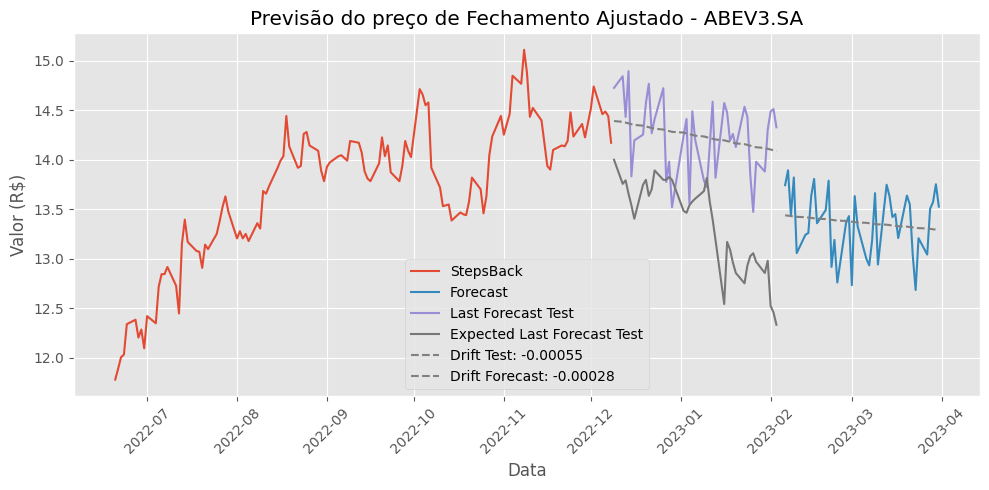

In [31]:
if graphics:
    plt.title(f"Previsão do preço de Fechamento Ajustado - {ticker}")
    plt.plot(df_test['Adj Close'][-observation_window['stepsBack']:- observation_window['stepsFoward']], label = 'StepsBack') 
    plt.plot(adj_close['Adj Close Forecast'][-observation_window['stepsFoward']:], label = 'Forecast') 
    plt.plot(adj_close['Adj Close Test'][:observation_window['stepsFoward']], label = 'Last Forecast Test') 
    plt.plot(adj_close['Real Adj Close Test'][:observation_window['stepsFoward']], label = 'Expected Last Forecast Test')

    plt.plot(adj_close_test.index, y_pred_test, label = f'Drift Test: {drift_test:.5f}', color='gray', linestyle='--') 
    plt.plot(adj_close_forecast.index, y_pred_forecast, label = f'Drift Forecast: {drift_forecast:.5f}', color='gray', linestyle='--') 

    plt.legend(loc = 'best')
    plt.xlabel('Data')
    plt.ylabel('Valor (R$)')
    plt.xticks(rotation=45)
    #plt.savefig(f'./results/prediction/{label}/Adj Close.png')
    #plt.close()
    plt.show()